# Module 16 - Electrostatic Potentials and Electric Fields in 2 and 3D

\begin{eqnarray}
\nabla \cdot \vec{E} &= \frac{\rho}{\varepsilon_0} \quad&\quad \nabla \times \vec{E} &= -\frac{\partial\vec{B}}{\partial t} \newline
\nabla \cdot \vec{B} &= 0 \quad&\quad \nabla \times \vec{B} &= \mu_0 \left(\vec{J} +\varepsilon_0 \frac{\partial\vec{E}}{\partial t}\right)
\end{eqnarray}

## Last Time

- Elliptical differential equations (Poisson/Laplace)
- Spatial discretization and the Laplace equation

## Today

- Numerical solution to Laplace's and Poisson's equation in 2D for realistic geometries

## Setting up the Notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

## Electric Field, Potential, Poisson and Laplace's Equations

Last time we showed that we can solve Poisson's equation

\begin{equation}
\frac{\partial^2}{\partial x^2} V(x,y,z) + \frac{\partial^2}{\partial y^2} V(x,y,z) + \frac{\partial^2}{\partial z^2} V(x,y,z) = -\frac{\rho(x,y,z)}{\varepsilon_0}.
\end{equation}

numerically using finite differences (assuming a cubic grid for simplicity, $\Delta x = \Delta y = \Delta z = \Delta$)

\begin{equation}
V(i,j,k) = \frac{1}{6} \left[V(i+1,j,k) + V(i-1,j,k) + V(i,j+1,k) + V(i,j-1,k) + V(i,j,k+1) + V(i,j,k-1) \right] + \frac{\rho(i,j,k)\Delta^2}{6\varepsilon_0}.
\end{equation}

In 2-dimensions $(x,y)$ the equation is simply

\begin{equation}
V(i,j) = \frac{1}{4} \left[V(i+1,j) + V(i-1,j) + V(i,j+1) + V(i,j-1) \right] + \frac{\rho(i,j)\Delta^2}{4\varepsilon_0}.
\end{equation}

We also showed that to find a solution to Poisson's equation we need to iteratively update the potential based on the values at a previous iteration

\begin{equation}
\tilde{V}(i,j,k,n+1) = \frac{1}{6} \left[\tilde{V}(i+1,j,k,n) + \tilde{V}(i-1,j,k,n) + \tilde{V}(i,j+1,k,n) + \tilde{V}(i,j-1,k,n) + \tilde{V}(i,j,k+1,n) + \tilde{V}(i,j,k-1,n) \right] + \frac{\rho(i,j,k)\Delta^2}{6\varepsilon_0},
\end{equation}

where the solution to the PDE is obtained in the limit of infinite number of iterations

\begin{equation}
V(i,j,k) = \tilde{V}(i,j,k,n \to \infty) \\
\\
\tilde{V}_0(i,j,k) \to \tilde{V}_1(i,j,k) \to \tilde{V}_2(i,j,k) \to \dots \to V(i,j,k).
\end{equation}

## A Realistic System - The Parallel Plate Capacitor in 2-dimensions

Today we are going to solve Laplace's equation ($\rho$ is zero for now) for a realistic parallel plate capacitor (not the ideal/infinite capacitor we solved in class last time) composed of two finite plates with equal but opposite potentials. First, we need to consider the geometry and boundary conditions of our system:
- **Geometry**
    - In 2 dimensions our system is a box of size $N_x \times N_y$ (same as the number of grid points, i.e., $dx = dy = 1$) with two 1D plates (length $2p$) located at $\frac{N_y}{2} \pm d$ and span the line enclosed by $\frac{N_x}{2} \pm p$.
- **Boundary conditions**
    - We will use fixed/Dirichlet boundary conditions at the edges of the simulation box. We will choose to have the value of the potential be zero at the edges. This can be readily done by setting the value of $V$ at the edges to $0$ at the beginning of the simulation and not updating the edges at any iteration. While the potential never exactly goes to zero, it is a reazonable approximation if the simulation edges are far from any charges or other regions with fixed potential values.
    - We can keep the potential at each plate fixed at a certain value ($V=1$ for the first plate and $V=-1$ for the second plate) in two different ways: 1) we can initialize it at the beginning of the simulation and not update the grid points afterwards, as we do with the simulation edges, or 2) we can reset the potential to the fixed values after each iteration update.

Last time we solved Laplace's equation and stored the value of the potential at each iteration to see the 'time' evolution of the numerical solution. However, we don't need to do this in general and only need to know the value of the potential at the previous iteration, $V_p(i,j,k)$, and the potential at the current iteration, $V(i,j,k)$. After completing each iteration we copy $V(i,j,k)$ into $V_p(i,j,k)$ to prepare for the next step.

1316


<IPython.core.display.Javascript object>


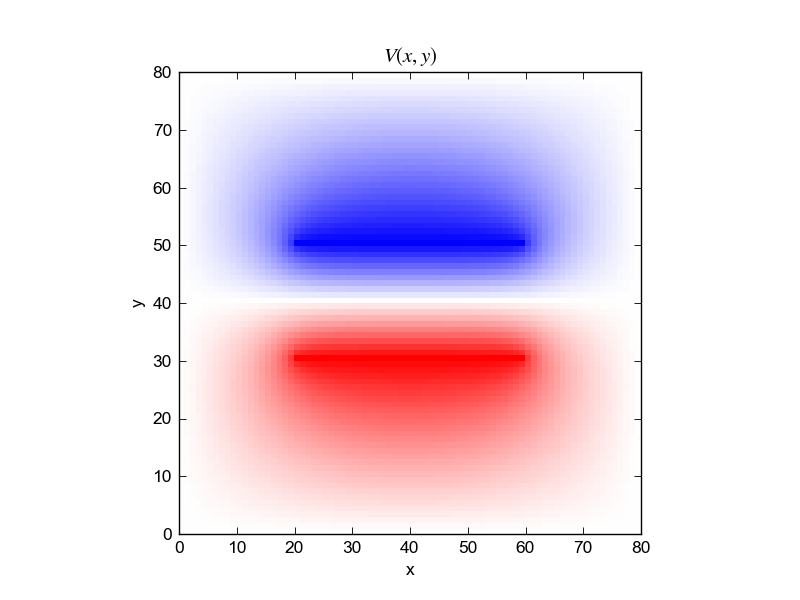

In [2]:
Nx = 80
Ny = 80
px = 20
d = 10

Vp = np.zeros((Nx,Ny))
V = np.zeros((Nx,Ny))

def fixPlatesV(V, Nx, Ny, px, d):
    for j in (Ny//2 - d,):
        for i in range(Nx//2 - px, Nx//2 + px):
            V[i,j] = 1.0

    for j in (Ny//2 + d,):
        for i in range(Nx//2 - px, Nx//2 + px):
            V[i,j] = -1.0
    return V

Vp = fixPlatesV(Vp, Nx, Ny, px, d)

dV = 1.0
t = 0
maxiter = 10000
tol = 1E-5

while (dV > tol) and (t < maxiter):
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            V[i,j] = (1.0/4)*(Vp[i-1,j] + Vp[i+1,j] + Vp[i,j+1] + Vp[i,j-1])
    V = fixPlatesV(V, Nx, Ny, px, d)
    dV = np.sum(np.abs(V - Vp))/(Nx*Ny)
    Vp = V.copy() # we need to use the 'deep' .copy() function, if we do Vp = V then Vp simply becomes an 'alias' of V
    t+=1
    
print(t)
plt.figure()
ax = plt.axes(aspect='equal')
ax.pcolormesh(V.T, cmap='bwr') # pcolormesh always interprets columns as x and rows as y
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(r'$V(x,y)$')

<div class="span alert alert-success">
<h2> Programming challenge </h2>
<br><br>
Create three plots to visualize the numerical solution to Laplace's equation:
<br><br>
1. Iso-contour plot using `plt.contour()` with 20 evenly distributed equipotential lines. Create two horizontal dashed lines using `plt.hlines()` that show the location of the two plates. Set the plot aspect ratio to be equal and use the 'bwr' colormap.
<br><br>
2. 3D surface of $V(x,y)$ using mplot3D's `Axes3D.plot_surface()`. Use `np.linspace()` and `np.meshgrid()` to generate the $x$ and $y$ coordinates for the plot.
<br><br>
3. Create a function `calcE(V, Nx, Ny)` that computes the electric field
<br><br>
\begin{align}
    E_x(i,j) &= - \frac{V(i+1,j) - V(i-1,j)}{2 \Delta y} \newline
    E_y(i,j) &= - \frac{V(i,j+1) - V(i,j-1)}{2 \Delta x}
\end{align}
<br>
from the numerically obtained potential. Create an iso-contour plot similar to the one from part 1 with fewer equipotential lines (~10) and add the electric field lines using `plt.quiver()`. Show only every fourth point in the quiver plot to improve visibility.
</div>

<IPython.core.display.Javascript object>


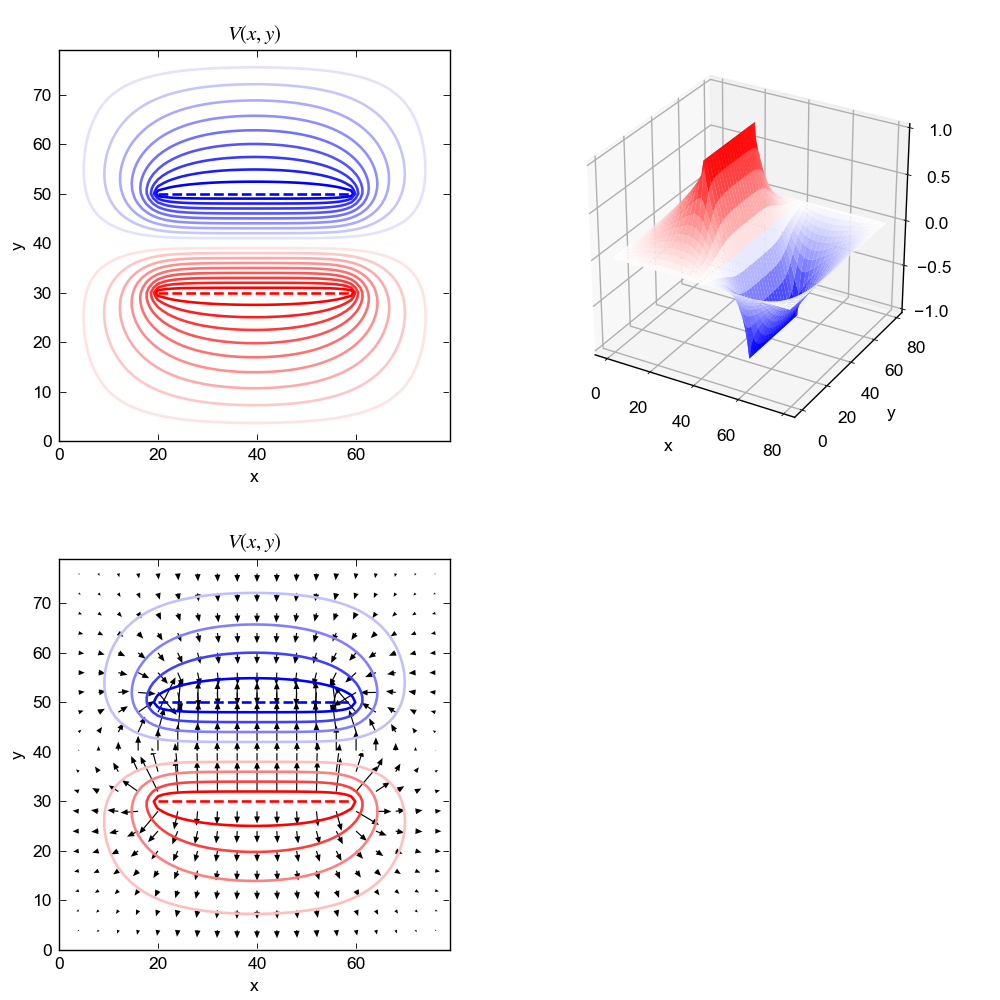

In [3]:
def calcE(V, Nx, Ny):
    Ex = np.zeros_like(V)
    Ey = np.zeros_like(V)
    for i in range(1,Nx-1):
        for j in range(1,Ny-1):
            Ex[i,j] = -0.5*(V[i+1,j]-V[i-1,j])
            Ey[i,j] = -0.5*(V[i,j+1]-V[i,j-1])
    return Ex, Ey

fig = plt.figure()
fig.set_size_inches((8,8))

# iso-contour plot
ax0 = plt.subplot(2,2,1)
ax0.set_aspect('equal')
ax0.hlines(y=Ny//2+d, xmin=Nx//2-px, xmax=Nx//2+px-1, color='b', linestyle='dashed')
ax0.hlines(y=Ny//2-d, xmin=Nx//2-px, xmax=Nx//2+px-1, color='r', linestyle='dashed')
ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax0.set_title(r'$V(x,y)$')
ax0.contour(V.T, locator=MaxNLocator(20), cmap='bwr')

# surface plot
ax1 = plt.subplot(2,2,2, projection='3d')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
x = np.linspace(0, Nx, Nx, endpoint=False)
y = np.linspace(0, Ny, Ny, endpoint=False)
X, Y = np.meshgrid(x, y)
ax1.plot_surface(X, Y, V, cmap='bwr')

Ex, Ey = calcE(V, Nx, Ny)

# iso-contour with E-field
ax2 = plt.subplot(2,2,3)
ax2.set_aspect('equal')
ax2.hlines(y=Ny//2+d, xmin=Nx//2-px, xmax=Nx//2+px-1, color='b', linestyle='dashed')
ax2.hlines(y=Ny//2-d, xmin=Nx//2-px, xmax=Nx//2+px-1, color='r', linestyle='dashed')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title(r'$V(x,y)$')
ax2.contour(V.T, locator=MaxNLocator(12), cmap='bwr')
ax2.quiver(x[::4],y[::4],Ex[::4,::4].T, Ey[::4,::4].T, headwidth=5, headlength=6, headaxislength=6)

plt.subplots_adjust(hspace=0.3, left=0.05, top=0.95, right=0.95, bottom=0.05)

## Parallel Plate Capacitor Redux - Two Plates of Uniform Charge Distribution

<div class="span alert alert-success">
<h2> Programming challenge </h2>
<br><br>
Extend our previous code to compute the potential for a similar system where instead of fixing the potential at the plates, we have a uniformly distributed charge of $+1$ on the first plate and $-1$ on the second plate. Create a new function `initRho()` based on the previous function `fixPlatesV()` that initializes the charge density, $\rho(i,j)$.
<br><br>
Create a similar set of plots for this system as we did for the other parallel plate capacitor.
</div>

In [9]:
Nx = 200
Ny = 200
px = 50
d = 10

Vp = np.zeros((Nx,Ny))
V = np.zeros((Nx,Ny))
rho = np.zeros((Nx,Ny))

def initRho(rho, Nx, Ny, px, d):
    c = 0
    for j in (Ny//2 - d,):
        for i in range(Nx//2 - px, Nx//2 + px):
            rho[i,j] = 1.0
            c+=1

    for j in (Ny//2 + d,):
        for i in range(Nx//2 - px, Nx//2 + px):
            rho[i,j] = -1.0
    return rho/c

rho = initRho(rho, Nx, Ny, px, d)

dV = 1.0
t = 0
maxiter = 10000
tol = 1E-6
while (dV > tol) and (t < maxiter):
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            V[i,j] = (1.0/4)*(Vp[i-1,j] + Vp[i+1,j] + Vp[i,j+1] + Vp[i,j-1]) + rho[i,j]/4
    dV = np.sum(np.abs(V - Vp))/(Nx*Ny)
    Vp = V.copy()
    t+=1
    
print(t)
plt.figure()
ax = plt.axes(aspect='equal')
ax.pcolormesh(V.T, cmap='bwr') # pcolormesh always interprets columns as x and rows as y
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(r'$V(x,y)$')

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


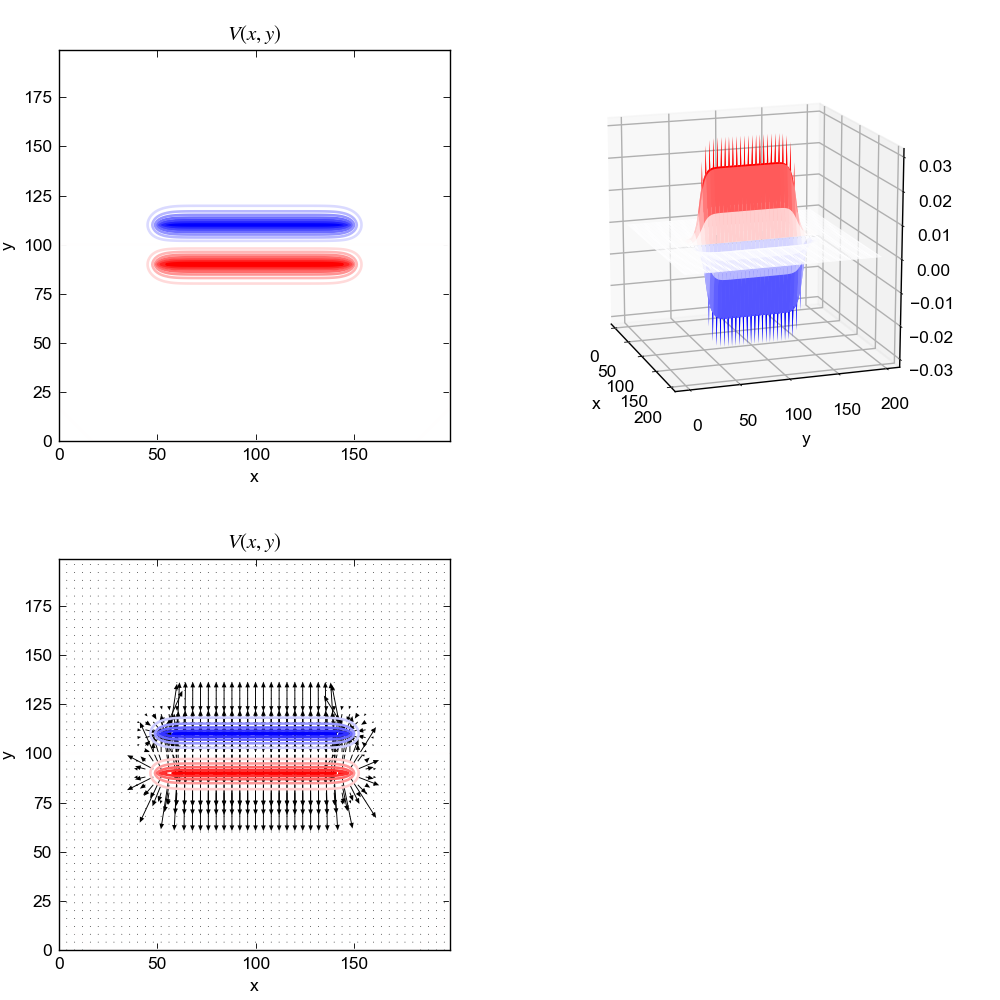

In [7]:
fig = plt.figure()
fig.set_size_inches((8,8))

# iso-contour plot
ax0 = plt.subplot(2,2,1)
ax0.set_aspect('equal')
ax0.hlines(y=Ny//2+d, xmin=Nx//2-px, xmax=Nx//2+px-1, color='b', linestyle='dashed')
ax0.hlines(y=Ny//2-d, xmin=Nx//2-px, xmax=Nx//2+px-1, color='r', linestyle='dashed')
ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax0.set_title(r'$V(x,y)$')
ax0.contour(V.T, locator=MaxNLocator(20), cmap='bwr')

# surface plot
ax1 = plt.subplot(2,2,2, projection='3d')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
x = np.linspace(0, Nx, Nx, endpoint=False)
y = np.linspace(0, Ny, Ny, endpoint=False)
X, Y = np.meshgrid(x, y)
ax1.plot_surface(X, Y, V, cmap='bwr')

Ex, Ey = calcE(V, Nx, Ny)

# iso-contour with E-field
ax2 = plt.subplot(2,2,3)
ax2.set_aspect('equal')
ax2.hlines(y=Ny//2+d, xmin=Nx//2-px, xmax=Nx//2+px-1, color='b', linestyle='dashed')
ax2.hlines(y=Ny//2-d, xmin=Nx//2-px, xmax=Nx//2+px-1, color='r', linestyle='dashed')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title(r'$V(x,y)$')
ax2.contour(V.T, locator=MaxNLocator(12), cmap='bwr')
ax2.quiver(x[::4],y[::4],Ex[::4,::4].T, Ey[::4,::4].T, headwidth=5, headlength=6, headaxislength=6)

plt.subplots_adjust(hspace=0.3, left=0.05, top=0.95, right=0.95, bottom=0.05)

## The Parallel Plate Capacitor in 3-dimensions

<div class="span alert alert-success">
<h2> Programming challenge </h2>
<br><br>
Extend our previous code to compute the potential for the parallel plate capacitor in 3 dimensions (the first case with constant $V$ at each plate). In this case our system is a box of size $N_x \times N_y \times N_z$ (same as the number of grid points, i.e., $dx = dy = dz = 1$) with two plates (size $2p_x \times 2p_y$) located at $\frac{N_z}{2} \pm d$ and span the area enclosed by $\frac{N_x}{2} \pm p_x$ and $\frac{N_y}{2} \pm p_y$.
<br><br>
The 3D problem is much more numerically intensive than in 2D, so you need to choose the system's dimensions wisely while testing. A reasonable choice to start with is $N_x = N_y = N_z = 20$, $p_x = p_y = 6$, $d=4$, and maxiter = 100.
<br><br>
Extend the function that calculates the electric field from the potential to 3 dimensions.
</div>

100


<IPython.core.display.Javascript object>


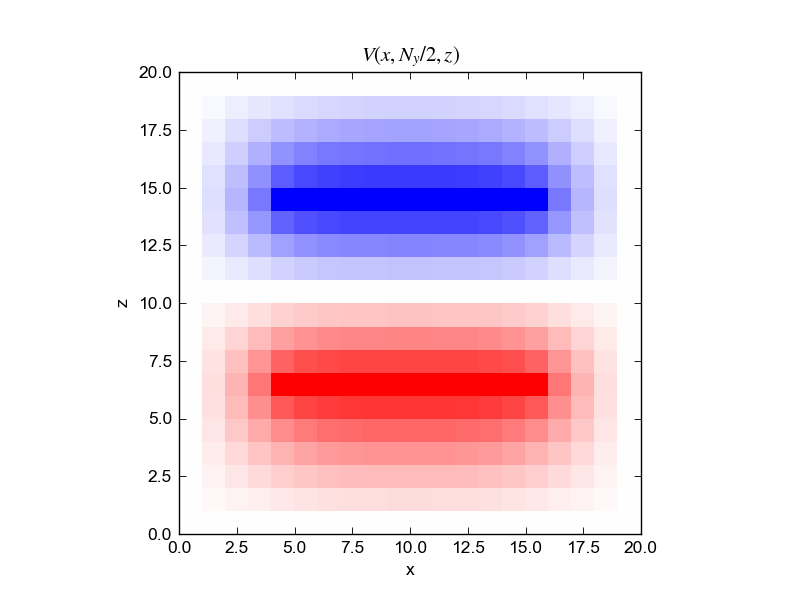

In [10]:
Nx = 20
Ny = 20
Nz = 20
px = 6
py = 4
d = 4

Vp = np.zeros((Nx,Ny,Nz))
V = np.zeros((Nx,Ny,Nz))

def fixPlatesV(V, Nx, Ny, Nz, px, py, d):
    for k in (Nz//2 - d,):
        for i in range(Nx//2 - px, Nx//2 + px):
            for j in range(Ny//2 - py, Ny//2 + py):
                V[i,j,k] = 1.0

    for k in (Nz//2 + d,):
        for i in range(Nx//2 - px, Nx//2 + px):
            for j in range(Ny//2 - py, Ny//2 + py):
                V[i,j,k] = -1.0
    return V

Vp = fixPlatesV(Vp, Nx, Ny, Nz, px, py, d)

dV = 1.0
t = 0
maxiter = 100
tol = 1E-5

while (dV > tol) and (t < maxiter):
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            for k in range(1, Nz-1):
                V[i,j,k] = (1.0/6.0)*(Vp[i-1,j,k] + Vp[i+1,j,k] + Vp[i,j+1,k] + Vp[i,j-1,k] +
                                      Vp[i,j,k+1] + Vp[i,j,k-1])
    V = fixPlatesV(V, Nx, Ny, Nz, px, py, d)
    dV = np.sum(np.abs(V - Vp))/(Nx*Ny*Nz)
    Vp = V.copy()
    t+=1
    
print(t)
plt.figure()
ax = plt.axes(aspect='equal')
ax.pcolormesh(V[:,Ny//2,:].T, cmap='bwr') # pcolormesh always interprets columns as x and rows as y
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_title(r'$V(x,N_y/2,z)$')

In [ ]:
def calcE(V, Nx, Ny, Nz):
    Ex = np.zeros_like(V)
    Ey = np.zeros_like(V)
    Ez = np.zeros_like(V)
    for i in range(1,Nx-1):
        for j in range(1,Ny-1):
            for k in range(1,Nz-1):
                Ex[i,j,k] = -0.5*(V[i+1,j,k]-V[i-1,j,k])
                Ey[i,j,k] = -0.5*(V[i,j+1,k]-V[i,j-1,k])
                Ez[i,j,k] = -0.5*(V[i,j,k+1]-V[i,j,k-1])
    return Ex, Ey, Ez

Ex, Ey, Ez = calcE(V, Nx, Ny, Nz)

## Saving the Data for External Visualization

So far we have done all data visualization within matplotlib, but sometimes we need more powerful tools for advanced visualizations. The first step is to save the data into a format that can be read by external programs. We will use ParaView (https://www.paraview.org/) to visualize the 3D data and we will save the numerical results using two simple file formats. The first is a simple comma separated text file where each line contains the $x$, $y$, and $z$ coordinates of each point and the corresponding data value, $V(x,y,z)$. The second one is the binary NetCDF format (see https://www.unidata.ucar.edu/software/netcdf/ and https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.io.netcdf.netcdf_file.html), which has been a long used standard. The NetCDF format is a bit more complex to use, but files occupy much less space.

<div class="span alert alert-success">
<h2> Programming challenge </h2>
<br><br>
Take the code below that creates a `csv` and `NetCDF` files for the potential and extend it to also create similar files for the electric field.
</div>

In [ ]:
f = open('potential.csv', 'w')

f.write('x, y, z, V\n') # Column header for paraview
for i in range(Nx):
    for j in range(Ny):
        for k in range(Nz):
            f.write('{0}, {1}, {2}, {3}\n'.format(i, j, k, V[i,j,k]))
f.close()

f = open('Efield.csv', 'w')
f.write('x, y, z, Ex, Ey, Ez\n') # Column header for paraview
for i in range(Nx):
    for j in range(Ny):
        for k in range(Nz):
            f.write('{0}, {1}, {2}, {3}, {4}, {5}\n'.format(i, j, k, Ex[i,j,k], Ey[i,j,k], Ez[i,j,k]))
f.close()

In [ ]:
from scipy.io import netcdf 

fp = netcdf.NetCDFFile('potential2.nc','w') # create and open a new NetCDF file

# Define the dimensions and set the units
fp.createDimension('x', Nx) # 'x' is the dimension name and Nx is the number of items along that dimension
x = fp.createVariable('x', 'd', ('x',)) # 'd' indicates data of type double
x[:] = np.linspace(0.0, Nx, Nx,endpoint=False) # could also be just x[:] = np.arange(0, Nx)
x.units = 'm'                               # x is not a simple numpy array so doing x = np.arange(0, Nx) won't work

fp.createDimension('y', Ny)
y = fp.createVariable('y', 'd', ('y',))
y[:] = np.linspace(0.0, Ny, Ny,endpoint=False)
y.units = 'm'

fp.createDimension('z', Nz)
z = fp.createVariable('z', 'd', ('z',))
z[:] = np.linspace(0.0, Nz, Nz,endpoint=False)
z.units = 'm'

# Store the data array
V_data       = fp.createVariable('Potential', 'd', ('z','y','x'))
V_data.units = 'V'
V_data[:]    = V.T

fp.close()

fp = netcdf.NetCDFFile('Efield2.nc','w') # create and open a new NetCDF file

# Define the dimensions and set the units
fp.createDimension('x', Nx) # 'x' is the dimension name and Nx is the number of items along that dimension
x = fp.createVariable('x', 'd', ('x',)) # 'd' indicates data of type double
x[:] = np.linspace(0.0, Nx, Nx,endpoint=False) # could also be just x[:] = np.arange(0, Nx)
x.units = 'm'                               # x is not a simple numpy array so doing x = np.arange(0, Nx) won't work

fp.createDimension('y', Ny)
y = fp.createVariable('y', 'd', ('y',))
y[:] = np.linspace(0.0, Ny, Ny,endpoint=False)
y.units = 'm'

fp.createDimension('z', Nz)
z = fp.createVariable('z', 'd', ('z',))
z[:] = np.linspace(0.0, Nz, Nz,endpoint=False)
z.units = 'm'

# Store the data array
Ex_data       = fp.createVariable('Ex', 'd', ('z','y','x'))
Ex_data.units = 'V/m'
Ex_data[:]    = Ex.T

Ey_data       = fp.createVariable('Ey', 'd', ('z','y','x'))
Ey_data.units = 'V/m'
Ey_data[:]    = Ey.T

Ez_data       = fp.createVariable('Ez', 'd', ('z','y','x'))
Ez_data.units = 'V/m'
Ez_data[:]    = Ez.T

fp.close()

ParaView:

- Open `.nc` file and select 'NetCDF files generic and CF conventions' and click 'ok, afterwards click 'Apply' on the left to actually open the file.
- Open `.csv` file and click 'Apply'. From the `Filters` menu select `Alphabetical > Table to Structured Grid`.
- Create contours, clips, and slices of the data
- After opening the file with the electric field, sse the `Calculator` filter to generate a 3D field from the individual components using `Ex*iHat + Ey*jHat + Ez*kHat` and give the Result Array Name 'Efield'.
- To visualize the electric field use `Glyph` filter.
- To only view the field on a selected region such as for example only the vectors on one of the equipotential surfaces use the `Resample With Dataset` filter. First create a new single contour at a certain value, then select the Efield (calculator) data in the pipeline and apply the filter. On the pop-up window select Efield as the `Input` and the single contour as the `Source`. You can then use the `Glyph` filter to create arrows for the newly resample field.